In [53]:
import pandas as pd
import numpy as np
import dill
import logging
import missingno

from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
from my_module__stat import *

from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import cross_validate,cross_val_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler 
import optuna


In [54]:
ga_hits = pd.read_csv('ga_hits.csv'#,nrows=1000000
)
ga_sessions = pd.read_csv('ga_sessions.csv'#,nrows=1000000
)

/tmp/ipykernel_168190/2704391487.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ga_sessions = pd.read_csv('ga_sessions.csv'#,nrows=1000000


In [55]:
ga_hits

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15726465,6866159858916559617.1640270865.1640270865,2021-12-23,810589.0,43,event,NaN,sberauto.com/cars/all/toyota/fortuner/24cb5af2...,quiz,quiz_show,NaN,NaN
15726466,7310304587364460692.1640261783.1640261783,2021-12-23,904927.0,40,event,NaN,sberauto.com/cars/all/mercedes-benz/gla-klasse...,quiz,quiz_show,NaN,NaN
15726467,8013702685784312179.1640270195.1640270195,2021-12-23,2172865.0,43,event,NaN,sberauto.com/cars/all/toyota/alphard/2ebe4871?...,quiz,quiz_show,NaN,NaN
15726468,8021505554734405918.1640257821.1640257821,2021-12-23,713325.0,45,event,NaN,sberauto.com/cars/all/bmw/x3/6a660f0a?rental_p...,quiz,quiz_show,NaN,NaN


In [56]:
ga_sessions

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.164016,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,VlqBmecIOXWjCWUmQkLd,desktop,Windows,NaN,NaN,1920x1080,Chrome,Russia,Moscow
1860038,9055421130527858185.1622007305.1622007305,2108379530.162201,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,390x844,Safari,Russia,Stavropol
1860039,9055422955903931195.1636979515.1636979515,2108379955.163697,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,375x667,Safari,Russia,Moscow
1860040,905543020766873816.1638189404.1638189404,210838164.163819,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,NaN,393x851,Chrome,Russia,Chelyabinsk


In [57]:
ga_hits['target'] = ga_hits['event_action'].isin(['sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click'])*1

In [58]:
grouped = ga_hits[['session_id','hit_number','target']].groupby('session_id').agg(max).reset_index()

/tmp/ipykernel_168190/3305300820.py:1: FutureWarning: The provided callable <built-in function max> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  grouped = ga_hits[['session_id','hit_number','target']].groupby('session_id').agg(max).reset_index()


In [59]:
grouped = grouped[['session_id','target']]

In [60]:
merged = ga_sessions.merge(grouped, on='session_id',how='inner')[list(ga_sessions.columns) + ['target']]

In [61]:
merged

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732261,9055415581448263752.1640159305.1640159305,2108378238.164016,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,VlqBmecIOXWjCWUmQkLd,desktop,Windows,NaN,NaN,1920x1080,Chrome,Russia,Moscow,0
1732262,9055421130527858185.1622007305.1622007305,2108379530.162201,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,390x844,Safari,Russia,Stavropol,0
1732263,9055422955903931195.1636979515.1636979515,2108379955.163697,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,375x667,Safari,Russia,Moscow,0
1732264,905543020766873816.1638189404.1638189404,210838164.163819,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,NaN,393x851,Chrome,Russia,Chelyabinsk,0


In [62]:
df = merged.copy()

In [63]:
# missingno.matrix(df)

In [64]:
df['utm_campaign'] = df['utm_campaign'].fillna('no_campaign')
df['utm_adcontent'] = df['utm_adcontent'].fillna('no_adcontent')
df['utm_keyword'] = df['utm_keyword'].fillna('no_keyword')
df['device_os'] = df['device_os'].fillna('unknown_device')
df['device_brand'] = df['device_brand'].fillna('unknown_device_brand')
del df['device_model']

In [65]:
df

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,no_campaign,NOBKLgtuvqYWkXQHeYWM,no_keyword,mobile,unknown_device,Xiaomi,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,no_campaign,no_adcontent,no_keyword,mobile,unknown_device,Xiaomi,393x786,Chrome,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732261,9055415581448263752.1640159305.1640159305,2108378238.164016,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,no_campaign,no_adcontent,VlqBmecIOXWjCWUmQkLd,desktop,Windows,unknown_device_brand,1920x1080,Chrome,Russia,Moscow,0
1732262,9055421130527858185.1622007305.1622007305,2108379530.162201,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,no_keyword,mobile,unknown_device,Apple,390x844,Safari,Russia,Stavropol,0
1732263,9055422955903931195.1636979515.1636979515,2108379955.163697,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,375x667,Safari,Russia,Moscow,0
1732264,905543020766873816.1638189404.1638189404,210838164.163819,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,Chelyabinsk,0


In [66]:
df = df.drop(columns=['client_id','visit_date'])

In [67]:
df.head()

,session_id,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,no_campaign,NOBKLgtuvqYWkXQHeYWM,no_keyword,mobile,unknown_device,Xiaomi,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,no_campaign,no_adcontent,no_keyword,mobile,unknown_device,Xiaomi,393x786,Chrome,Russia,Moscow,0


In [68]:
df['visit_time'] = pd.to_datetime(df.visit_time).dt.hour
df.loc[~df['utm_source'].isin(df['utm_source'].value_counts().head(20).index),'utm_source'] = 'other'
df.loc[~df['utm_medium'].isin(df['utm_medium'].value_counts().head(10).index),'utm_medium'] = 'other'
df.loc[~df['utm_campaign'].isin(df['utm_campaign'].value_counts().head(30).index),'utm_campaign'] = 'other'
df.loc[~df['utm_adcontent'].isin(df['utm_adcontent'].value_counts().head(15).index),'utm_adcontent'] = 'other'
df.loc[~df['utm_keyword'].isin(df['utm_keyword'].value_counts().head(30).index),'utm_keyword'] = 'other'
df.loc[~df['device_os'].isin(df['device_os'].value_counts().head(6).index),'device_os'] = 'other'
df.loc[~df['device_brand'].isin(df['device_brand'].value_counts().head(10).index),'device_brand'] = 'other'
df.loc[~df['device_browser'].isin(df['device_browser'].value_counts().head(7).index),'device_browser'] = 'other'
df.loc[~df['geo_country'].isin(df['geo_country'].value_counts().head(3).index),'geo_country'] = 'other'
df.loc[~df['geo_city'].isin(df['geo_city'].value_counts().head(50).index),'geo_city'] = 'other'

/tmp/ipykernel_168190/1358828731.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['visit_time'] = pd.to_datetime(df.visit_time).dt.hour


In [69]:
def mul(s):
    l = s.split('x')
    return int(l[0])*int(l[1])
df['screen_square'] = df['device_screen_resolution'].apply(lambda x:mul(x))

In [70]:
del df['device_screen_resolution']

In [71]:
df['session_id']

0          9055434745589932991.1637753792.1637753792
1           905544597018549464.1636867290.1636867290
2          9055446045651783499.1640648526.1640648526
3          9055447046360770272.1622255328.1622255328
4          9055447046360770272.1622255345.1622255345
                             ...                    
1732261    9055415581448263752.1640159305.1640159305
1732262    9055421130527858185.1622007305.1622007305
1732263    9055422955903931195.1636979515.1636979515
1732264     905543020766873816.1638189404.1638189404
1732265    9055430416266113553.1640968742.1640968742
Name: session_id, Length: 1732266, dtype: object

In [72]:
df

,session_id,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_browser,geo_country,geo_city,target,screen_square
0,9055434745589932991.1637753792.1637753792,14,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,Chrome,Russia,other,0,259200
1,905544597018549464.1636867290.1636867290,8,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,Samsung Internet,Russia,Moscow,0,328790
2,9055446045651783499.1640648526.1640648526,2,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,0,259200
3,9055447046360770272.1622255328.1622255328,5,1,kjsLglQLzykiRbcDiGcD,cpc,no_campaign,other,no_keyword,mobile,unknown_device,Xiaomi,Chrome,Russia,Moscow,0,308898
4,9055447046360770272.1622255345.1622255345,5,2,kjsLglQLzykiRbcDiGcD,cpc,no_campaign,no_adcontent,no_keyword,mobile,unknown_device,Xiaomi,Chrome,Russia,Moscow,0,308898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732261,9055415581448263752.1640159305.1640159305,10,1,BHcvLfOaCWvWTykYqHVe,cpc,no_campaign,no_adcontent,other,desktop,Windows,unknown_device_brand,Chrome,Russia,Moscow,0,2073600
1732262,9055421130527858185.1622007305.1622007305,8,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,no_keyword,mobile,unknown_device,Apple,Safari,Russia,Stavropol,0,329160
1732263,9055422955903931195.1636979515.1636979515,15,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,Safari,Russia,Moscow,0,250125
1732264,905543020766873816.1638189404.1638189404,15,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,Chrome,Russia,Chelyabinsk,0,334443


In [73]:
df.rename(columns={'event_action_bool':'target'},inplace=True)

In [74]:
cat_cols = df.select_dtypes('object').drop(columns='session_id').columns

In [75]:
# for col in cat_cols:
#     pivot = df.pivot_table(
#     values='session_id',
#     index='target',
#     columns=col,
#     aggfunc='count',
#     fill_value=0,
#     margins=True)

#     pivot = pivot.iloc[:-1,:-1]
    
#     graph_contingency_tables_bar_freqint(
#     data_df_in=pivot,
#     graph_inclusion='arf',
#     title_figure = col, title_figure_fontsize = 16,
#     result_output=True,
#     tight_layout=False,
#     graph_size=(297/INCH*1.5, 210/INCH/1.25)
#     )


In [76]:
X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

random_state=42

In [77]:
vc =  y_train.value_counts()

disbalance = vc[1]/vc[0]

In [78]:
OverS = RandomOverSampler(random_state=42)

X_Over, Y_Over = OverS.fit_resample(X_train, y_train)
df_over = X_Over.copy()
df_over['target'] = Y_Over

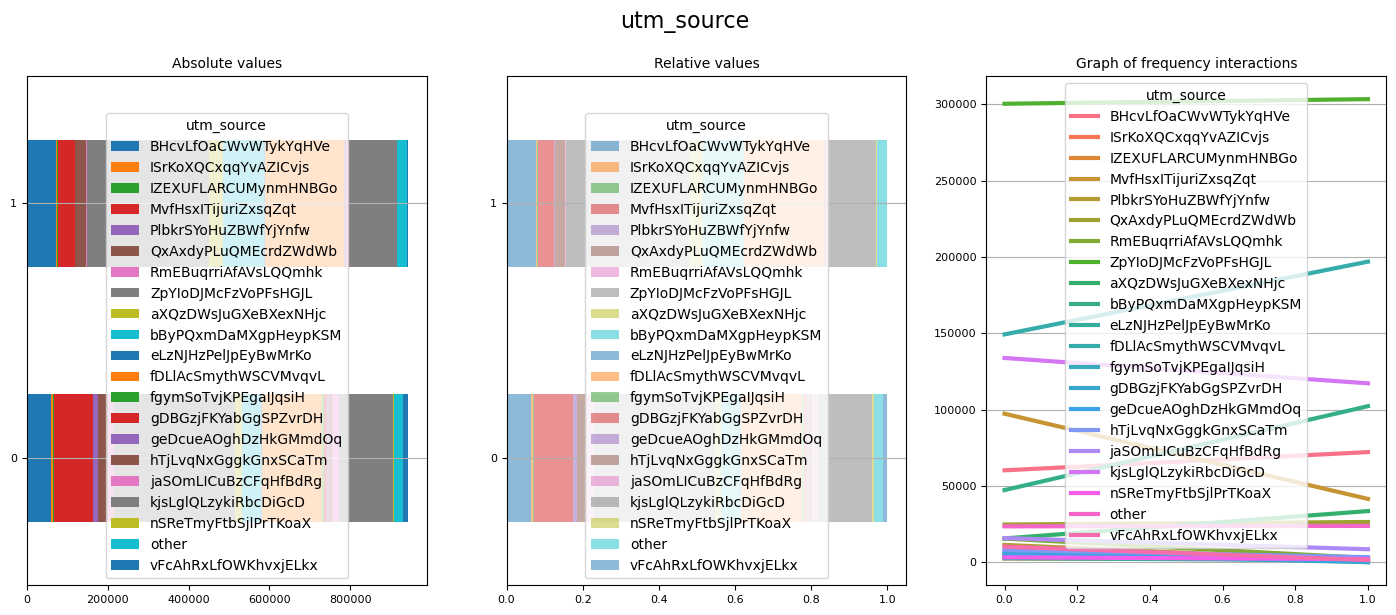


Absolute values:


utm_source,BHcvLfOaCWvWTykYqHVe,ISrKoXQCxqqYvAZICvjs,IZEXUFLARCUMynmHNBGo,MvfHsxITijuriZxsqZqt,PlbkrSYoHuZBWfYjYnfw,QxAxdyPLuQMEcrdZWdWb,RmEBuqrriAfAVsLQQmhk,ZpYIoDJMcFzVoPFsHGJL,aXQzDWsJuGXeBXexNHjc,bByPQxmDaMXgpHeypKSM,...,fgymSoTvjKPEgaIJqsiH,gDBGzjFKYabGgSPZvrDH,geDcueAOghDzHkGMmdOq,hTjLvqNxGggkGnxSCaTm,jaSOmLICuBzCFqHfBdRg,kjsLglQLzykiRbcDiGcD,nSReTmyFtbSjlPrTKoaX,other,vFcAhRxLfOWKhvxjELkx,sum
target,,,,,,,,,,,,,,,,,,,,,
0,60155,4275,2386,97259,11285,24638,15416,300373,15522,47214,...,5397,7450,4576,7942,15731,133785,3153,23448,10156,941931
1,72098,2584,1796,41424,921,26305,2702,303397,33456,102203,...,0,0,916,3275,8439,117174,1976,23745,1338,941931



Relative values:


utm_source,BHcvLfOaCWvWTykYqHVe,ISrKoXQCxqqYvAZICvjs,IZEXUFLARCUMynmHNBGo,MvfHsxITijuriZxsqZqt,PlbkrSYoHuZBWfYjYnfw,QxAxdyPLuQMEcrdZWdWb,RmEBuqrriAfAVsLQQmhk,ZpYIoDJMcFzVoPFsHGJL,aXQzDWsJuGXeBXexNHjc,bByPQxmDaMXgpHeypKSM,...,fgymSoTvjKPEgaIJqsiH,gDBGzjFKYabGgSPZvrDH,geDcueAOghDzHkGMmdOq,hTjLvqNxGggkGnxSCaTm,jaSOmLICuBzCFqHfBdRg,kjsLglQLzykiRbcDiGcD,nSReTmyFtbSjlPrTKoaX,other,vFcAhRxLfOWKhvxjELkx,sum
target,,,,,,,,,,,,,,,,,,,,,
0,0.063863,0.004539,0.002533,0.103255,0.011981,0.026157,0.016366,0.318891,0.016479,0.050125,...,0.00573,0.007909,0.004858,0.008432,0.016701,0.142033,0.003347,0.024894,0.010782,1.0
1,0.076543,0.002743,0.001907,0.043978,0.000978,0.027927,0.002869,0.322101,0.035519,0.108504,...,0.00000,0.000000,0.000972,0.003477,0.008959,0.124398,0.002098,0.025209,0.001420,1.0


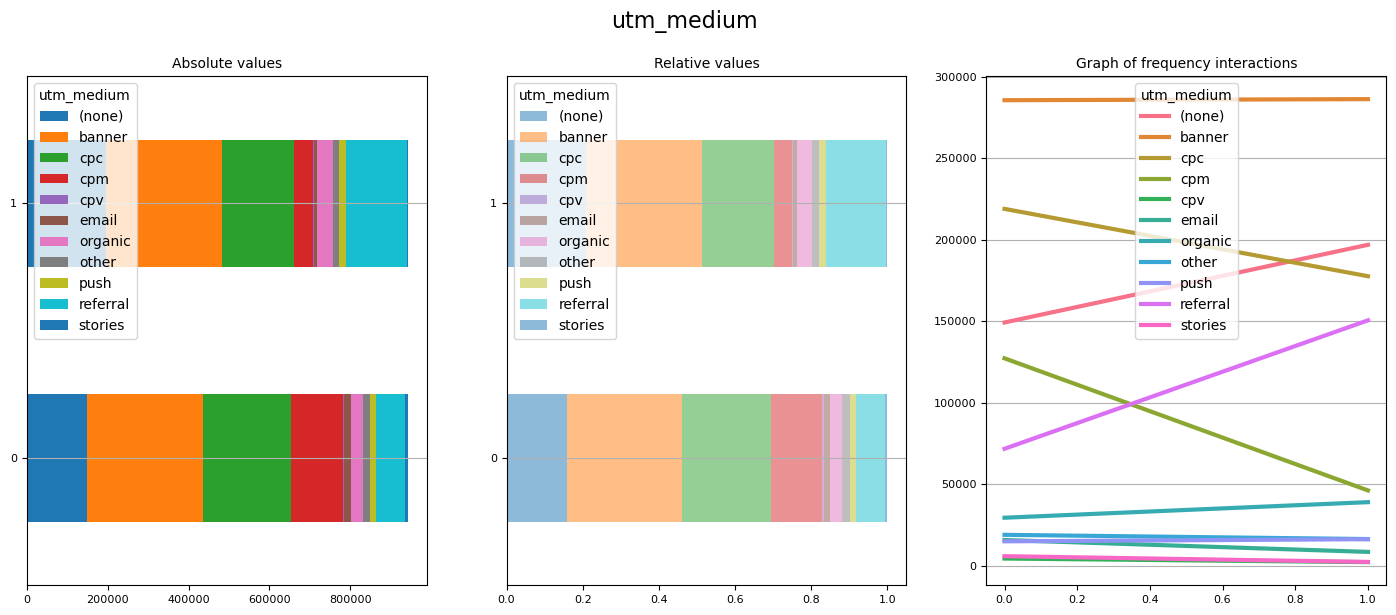


Absolute values:


utm_medium,(none),banner,cpc,cpm,cpv,email,organic,other,push,referral,stories,sum
target,,,,,,,,,,,,
0,149226,285645,218946,127240,4368,15732,29408,18910,14931,71722,5803,941931
1,196909,286299,177626,46155,2160,8439,38963,16317,16233,150551,2279,941931



Relative values:


utm_medium,(none),banner,cpc,cpm,cpv,email,organic,other,push,referral,stories,sum
target,,,,,,,,,,,,
0,0.158426,0.303255,0.232444,0.135084,0.004637,0.016702,0.031221,0.020076,0.015851,0.076144,0.006161,1.0
1,0.209048,0.303949,0.188576,0.049000,0.002293,0.008959,0.041365,0.017323,0.017234,0.159832,0.002419,1.0


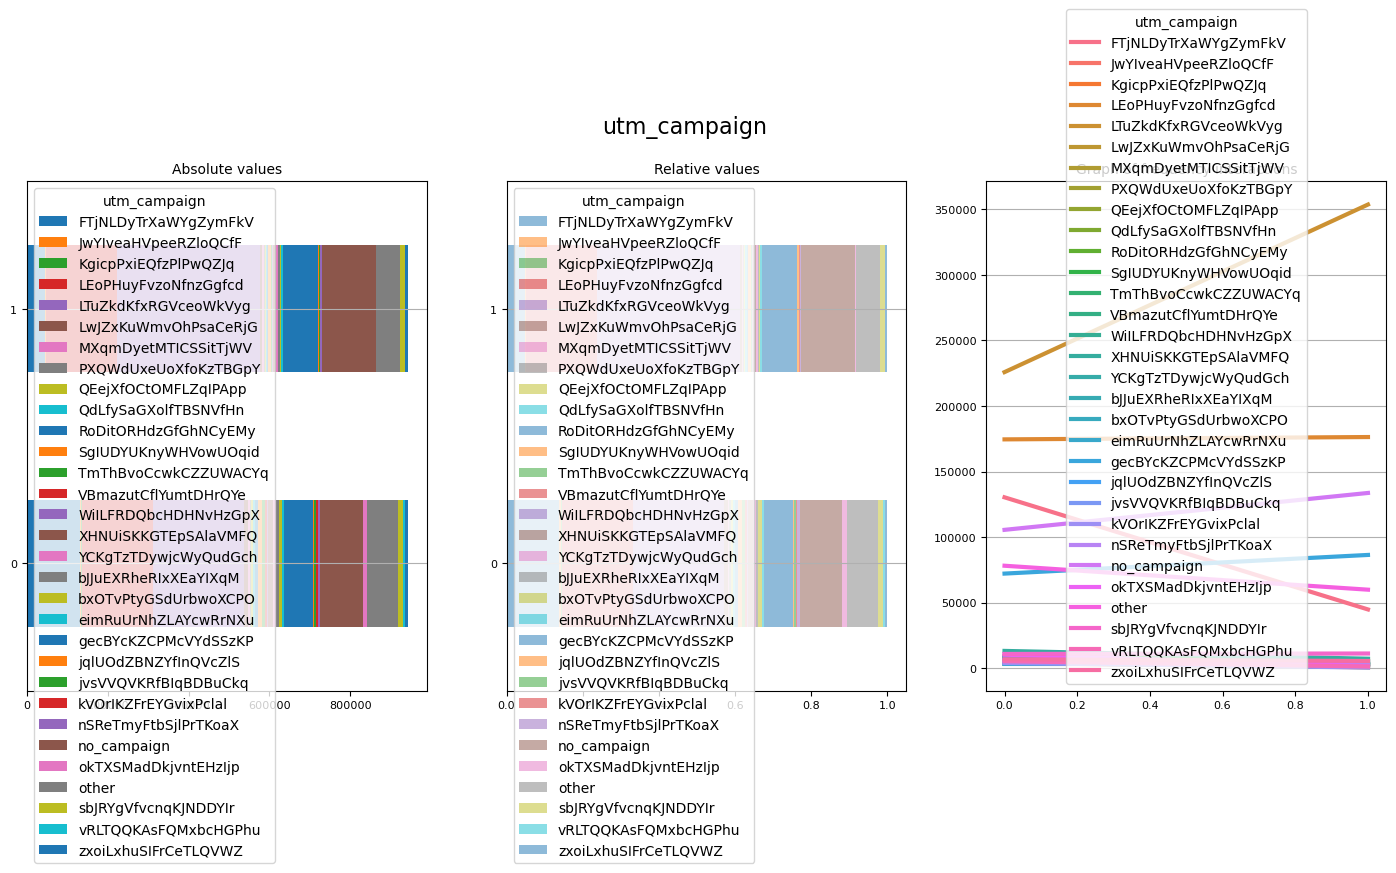


Absolute values:


utm_campaign,FTjNLDyTrXaWYgZymFkV,JwYIveaHVpeeRZloQCfF,KgicpPxiEQfzPlPwQZJq,LEoPHuyFvzoNfnzGgfcd,LTuZkdKfxRGVceoWkVyg,LwJZxKuWmvOhPsaCeRjG,MXqmDyetMTICSSitTjWV,PXQWdUxeUoXfoKzTBGpY,QEejXfOCtOMFLZqIPApp,QdLfySaGXolfTBSNVfHn,...,jvsVVQVKRfBIqBDBuCkq,kVOrIKZFrEYGvixPclal,nSReTmyFtbSjlPrTKoaX,no_campaign,okTXSMadDkjvntEHzIjp,other,sbJRYgVfvcnqKJNDDYIr,vRLTQQKAsFQMxbcHGPhu,zxoiLxhuSIFrCeTLQVWZ,sum
target,,,,,,,,,,,,,,,,,,,,,
0,130317,3527,3796,174535,225865,9386,3829,3767,5574,3692,...,4240,3905,6207,105491,10208,78104,10781,5225,6706,941931
1,44743,2042,591,176317,353752,5230,3300,2206,2352,2998,...,1918,420,4515,133642,1407,59828,11119,1209,5410,941931



Relative values:


utm_campaign,FTjNLDyTrXaWYgZymFkV,JwYIveaHVpeeRZloQCfF,KgicpPxiEQfzPlPwQZJq,LEoPHuyFvzoNfnzGgfcd,LTuZkdKfxRGVceoWkVyg,LwJZxKuWmvOhPsaCeRjG,MXqmDyetMTICSSitTjWV,PXQWdUxeUoXfoKzTBGpY,QEejXfOCtOMFLZqIPApp,QdLfySaGXolfTBSNVfHn,...,jvsVVQVKRfBIqBDBuCkq,kVOrIKZFrEYGvixPclal,nSReTmyFtbSjlPrTKoaX,no_campaign,okTXSMadDkjvntEHzIjp,other,sbJRYgVfvcnqKJNDDYIr,vRLTQQKAsFQMxbcHGPhu,zxoiLxhuSIFrCeTLQVWZ,sum
target,,,,,,,,,,,,,,,,,,,,,
0,0.138351,0.003744,0.004030,0.185295,0.239789,0.009965,0.004065,0.003999,0.005918,0.003920,...,0.004501,0.004146,0.006590,0.111994,0.010837,0.082919,0.011446,0.005547,0.007119,1.0
1,0.047501,0.002168,0.000627,0.187187,0.375560,0.005552,0.003503,0.002342,0.002497,0.003183,...,0.002036,0.000446,0.004793,0.141881,0.001494,0.063516,0.011804,0.001284,0.005744,1.0


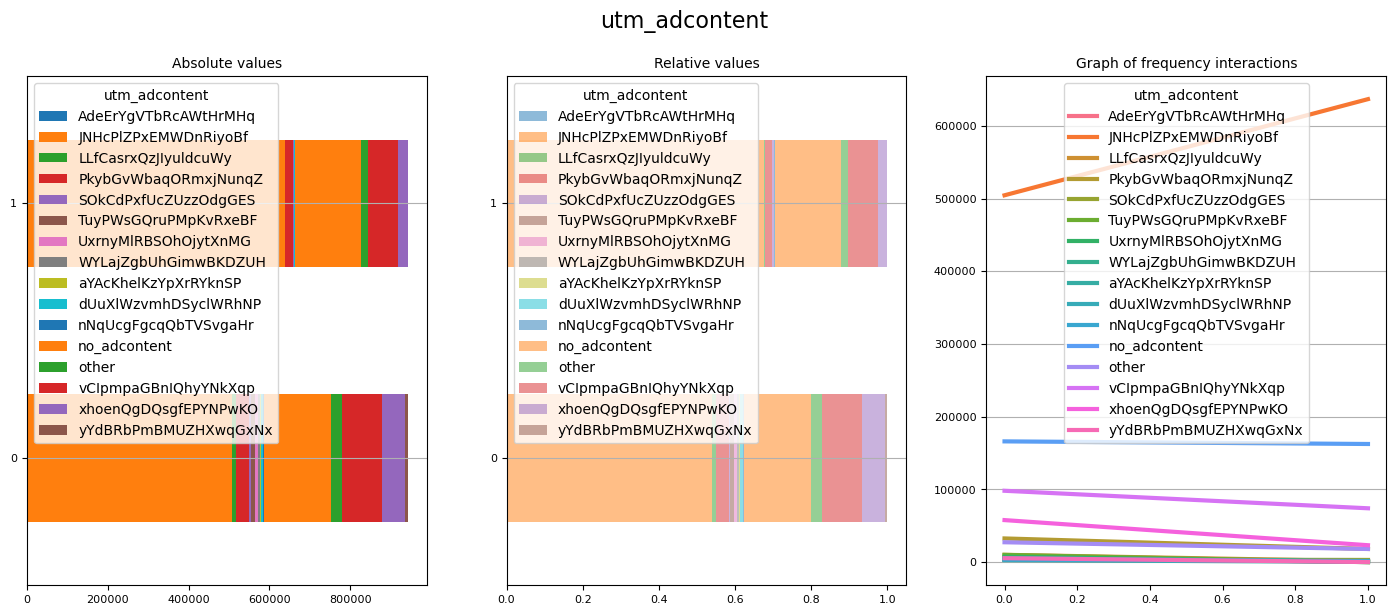


Absolute values:


utm_adcontent,AdeErYgVTbRcAWtHrMHq,JNHcPlZPxEMWDnRiyoBf,LLfCasrxQzJIyuldcuWy,PkybGvWbaqORmxjNunqZ,SOkCdPxfUcZUzzOdgGES,TuyPWsGQruPMpKvRxeBF,UxrnyMlRBSOhOjytXnMG,WYLajZgbUhGimwBKDZUH,aYAcKhelKzYpXrRYknSP,dUuXlWzvmhDSyclWRhNP,nNqUcgFgcqQbTVSvgaHr,no_adcontent,other,vCIpmpaGBnIQhyYNkXqp,xhoenQgDQsgfEPYNPwKO,yYdBRbPmBMUZHXwqGxNx,sum
target,,,,,,,,,,,,,,,,,
0,3080,504423,10055,32565,3590,9935,7462,4541,2700,5538,3341,166037,27312,98116,57800,5436,941931
1,1273,636634,1290,18122,2998,0,0,854,478,806,1571,162447,18062,74032,23261,103,941931



Relative values:


utm_adcontent,AdeErYgVTbRcAWtHrMHq,JNHcPlZPxEMWDnRiyoBf,LLfCasrxQzJIyuldcuWy,PkybGvWbaqORmxjNunqZ,SOkCdPxfUcZUzzOdgGES,TuyPWsGQruPMpKvRxeBF,UxrnyMlRBSOhOjytXnMG,WYLajZgbUhGimwBKDZUH,aYAcKhelKzYpXrRYknSP,dUuXlWzvmhDSyclWRhNP,nNqUcgFgcqQbTVSvgaHr,no_adcontent,other,vCIpmpaGBnIQhyYNkXqp,xhoenQgDQsgfEPYNPwKO,yYdBRbPmBMUZHXwqGxNx,sum
target,,,,,,,,,,,,,,,,,
0,0.003270,0.535520,0.010675,0.034573,0.003811,0.010547,0.007922,0.004821,0.002866,0.005879,0.003547,0.176273,0.028996,0.104165,0.061363,0.005771,1.0
1,0.001351,0.675882,0.001370,0.019239,0.003183,0.000000,0.000000,0.000907,0.000507,0.000856,0.001668,0.172462,0.019176,0.078596,0.024695,0.000109,1.0


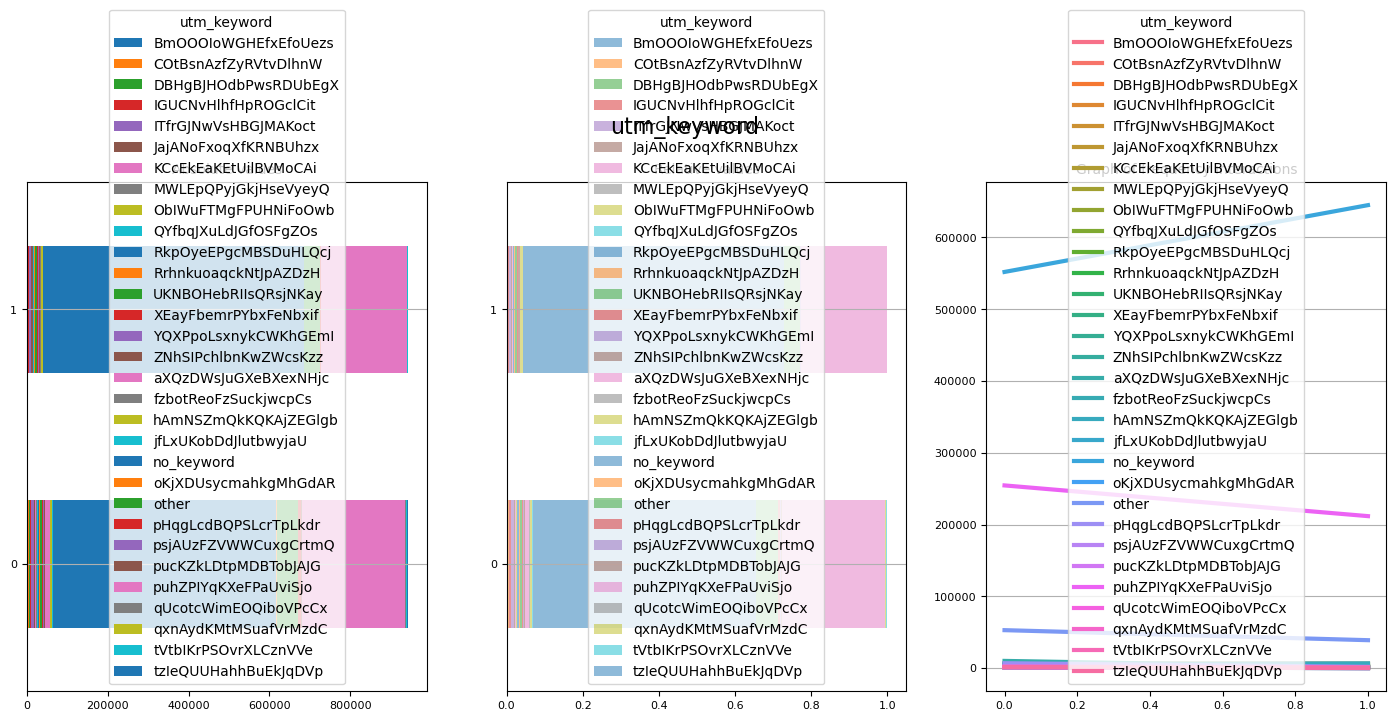


Absolute values:


utm_keyword,BmOOOIoWGHEfxEfoUezs,COtBsnAzfZyRVtvDlhnW,DBHgBJHOdbPwsRDUbEgX,IGUCNvHlhfHpROGclCit,ITfrGJNwVsHBGJMAKoct,JajANoFxoqXfKRNBUhzx,KCcEkEaKEtUilBVMoCAi,MWLEpQPyjGkjHseVyeyQ,ObIWuFTMgFPUHNiFoOwb,QYfbqJXuLdJGfOSFgZOs,...,other,pHqgLcdBQPSLcrTpLkdr,psjAUzFZVWWCuxgCrtmQ,pucKZkLDtpMDBTobJAJG,puhZPIYqKXeFPaUviSjo,qUcotcWimEOQiboVPcCx,qxnAydKMtMSuafVrMzdC,tVtbIKrPSOvrXLCznVVe,tzIeQUUHahhBuEkJqDVp,sum
target,,,,,,,,,,,,,,,,,,,,,
0,3390,1427,2269,3786,6760,3449,1382,1642,1397,1356,...,52901,6843,1305,2545,254551,1334,1279,1904,1443,941931
1,956,1036,741,2207,6172,2935,1291,562,0,1140,...,38932,1793,961,1273,211751,0,415,883,184,941931



Relative values:


utm_keyword,BmOOOIoWGHEfxEfoUezs,COtBsnAzfZyRVtvDlhnW,DBHgBJHOdbPwsRDUbEgX,IGUCNvHlhfHpROGclCit,ITfrGJNwVsHBGJMAKoct,JajANoFxoqXfKRNBUhzx,KCcEkEaKEtUilBVMoCAi,MWLEpQPyjGkjHseVyeyQ,ObIWuFTMgFPUHNiFoOwb,QYfbqJXuLdJGfOSFgZOs,...,other,pHqgLcdBQPSLcrTpLkdr,psjAUzFZVWWCuxgCrtmQ,pucKZkLDtpMDBTobJAJG,puhZPIYqKXeFPaUviSjo,qUcotcWimEOQiboVPcCx,qxnAydKMtMSuafVrMzdC,tVtbIKrPSOvrXLCznVVe,tzIeQUUHahhBuEkJqDVp,sum
target,,,,,,,,,,,,,,,,,,,,,
0,0.003599,0.001515,0.002409,0.004019,0.007177,0.003662,0.001467,0.001743,0.001483,0.00144,...,0.056162,0.007265,0.001385,0.002702,0.270244,0.001416,0.001358,0.002021,0.001532,1.0
1,0.001015,0.001100,0.000787,0.002343,0.006552,0.003116,0.001371,0.000597,0.000000,0.00121,...,0.041332,0.001904,0.001020,0.001351,0.224805,0.000000,0.000441,0.000937,0.000195,1.0


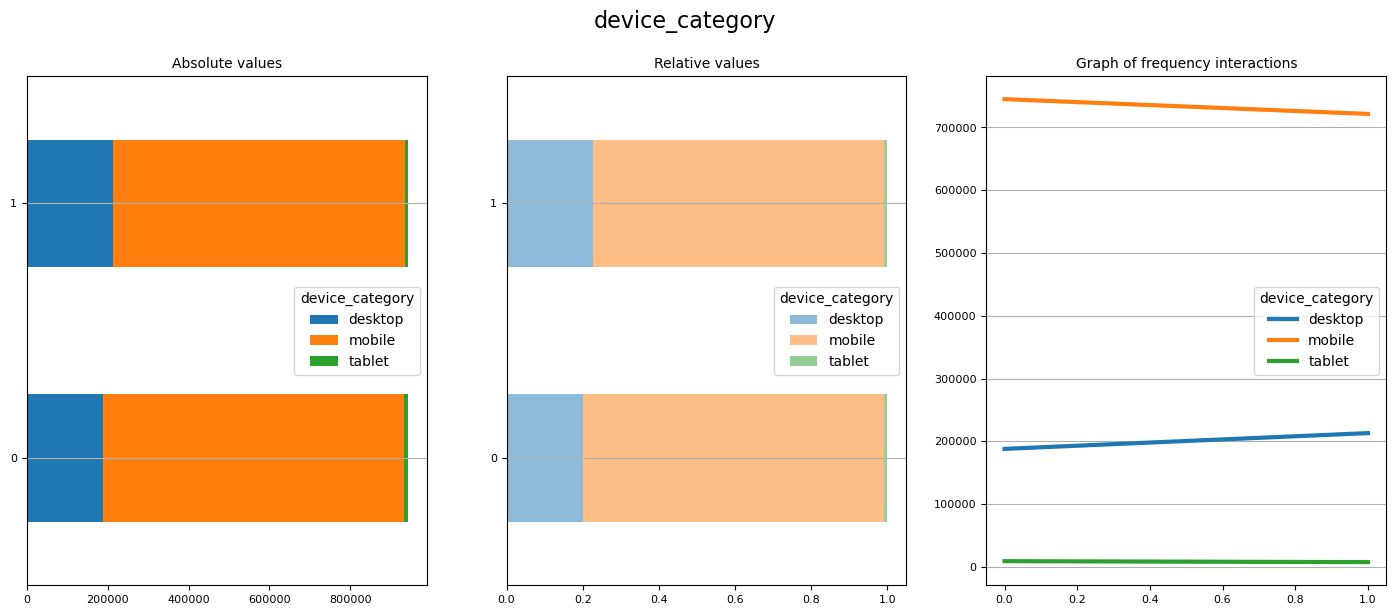


Absolute values:


device_category,desktop,mobile,tablet,sum
target,,,,
0,187912,744969,9050,941931
1,213025,721386,7520,941931



Relative values:


device_category,desktop,mobile,tablet,sum
target,,,,
0,0.199497,0.790896,0.009608,1.0
1,0.226158,0.765859,0.007984,1.0


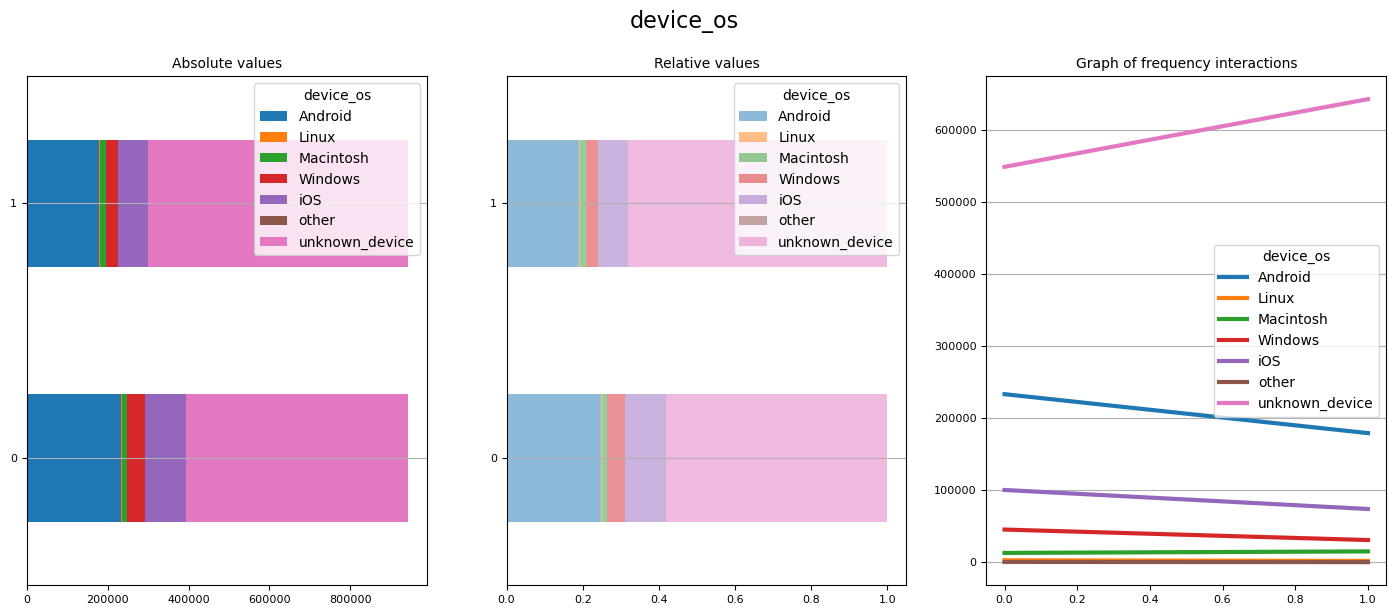


Absolute values:


device_os,Android,Linux,Macintosh,Windows,iOS,other,unknown_device,sum
target,,,,,,,,
0,232943,2529,12778,45166,100052,241,548222,941931
1,178931,1652,14869,30643,73702,0,642134,941931



Relative values:


device_os,Android,Linux,Macintosh,Windows,iOS,other,unknown_device,sum
target,,,,,,,,
0,0.247304,0.002685,0.013566,0.047950,0.106220,0.000256,0.582019,1.0
1,0.189962,0.001754,0.015786,0.032532,0.078246,0.000000,0.681721,1.0


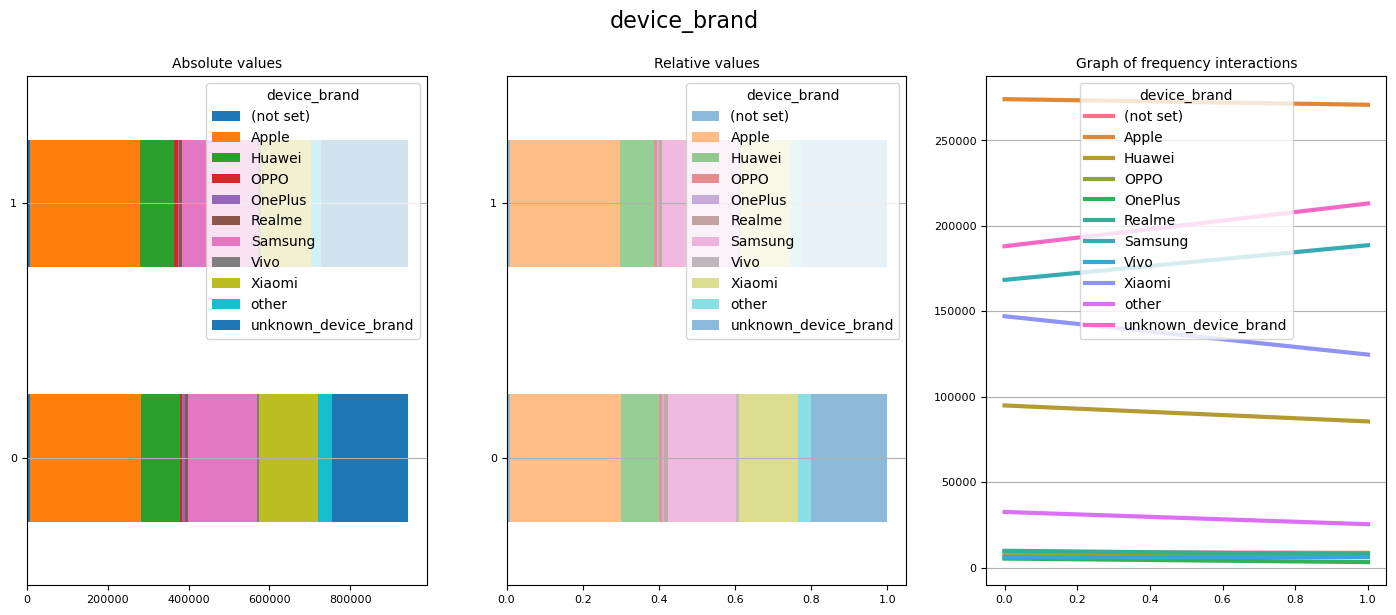


Absolute values:


device_brand,(not set),Apple,Huawei,OPPO,OnePlus,Realme,Samsung,Vivo,Xiaomi,other,unknown_device_brand,sum
target,,,,,,,,,,,,
0,8902,274176,94859,6892,5235,9791,168374,5993,147106,32531,188072,941931
1,8591,270882,85510,8293,3148,7733,188671,6027,124634,25346,213096,941931



Relative values:


device_brand,(not set),Apple,Huawei,OPPO,OnePlus,Realme,Samsung,Vivo,Xiaomi,other,unknown_device_brand,sum
target,,,,,,,,,,,,
0,0.009451,0.291079,0.100707,0.007317,0.005558,0.010395,0.178754,0.006362,0.156175,0.034537,0.199666,1.0
1,0.009121,0.287582,0.090782,0.008804,0.003342,0.008210,0.200302,0.006399,0.132318,0.026909,0.226233,1.0


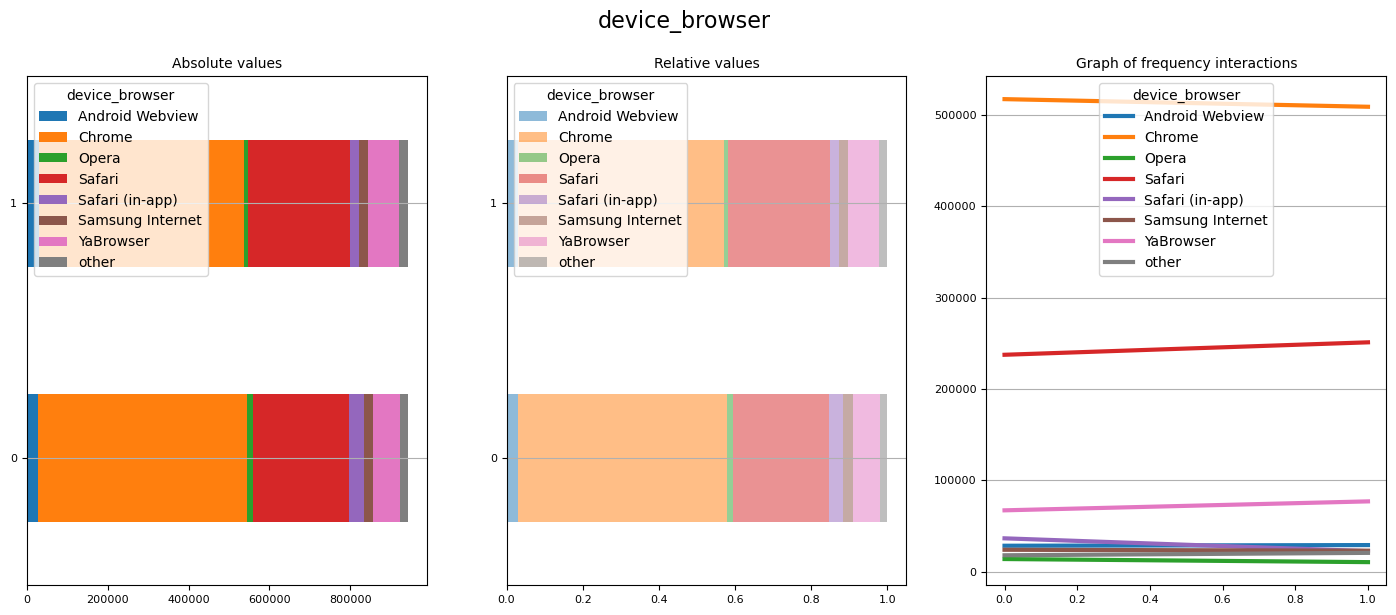


Absolute values:


device_browser,Android Webview,Chrome,Opera,Safari,Safari (in-app),Samsung Internet,YaBrowser,other,sum
target,,,,,,,,,
0,28302,517292,13737,237385,36411,23884,67065,17855,941931
1,29022,508942,10352,251017,22353,22889,76858,20498,941931



Relative values:


device_browser,Android Webview,Chrome,Opera,Safari,Safari (in-app),Samsung Internet,YaBrowser,other,sum
target,,,,,,,,,
0,0.030047,0.549182,0.014584,0.252020,0.038656,0.025356,0.071199,0.018956,1.0
1,0.030811,0.540318,0.010990,0.266492,0.023731,0.024300,0.081596,0.021762,1.0


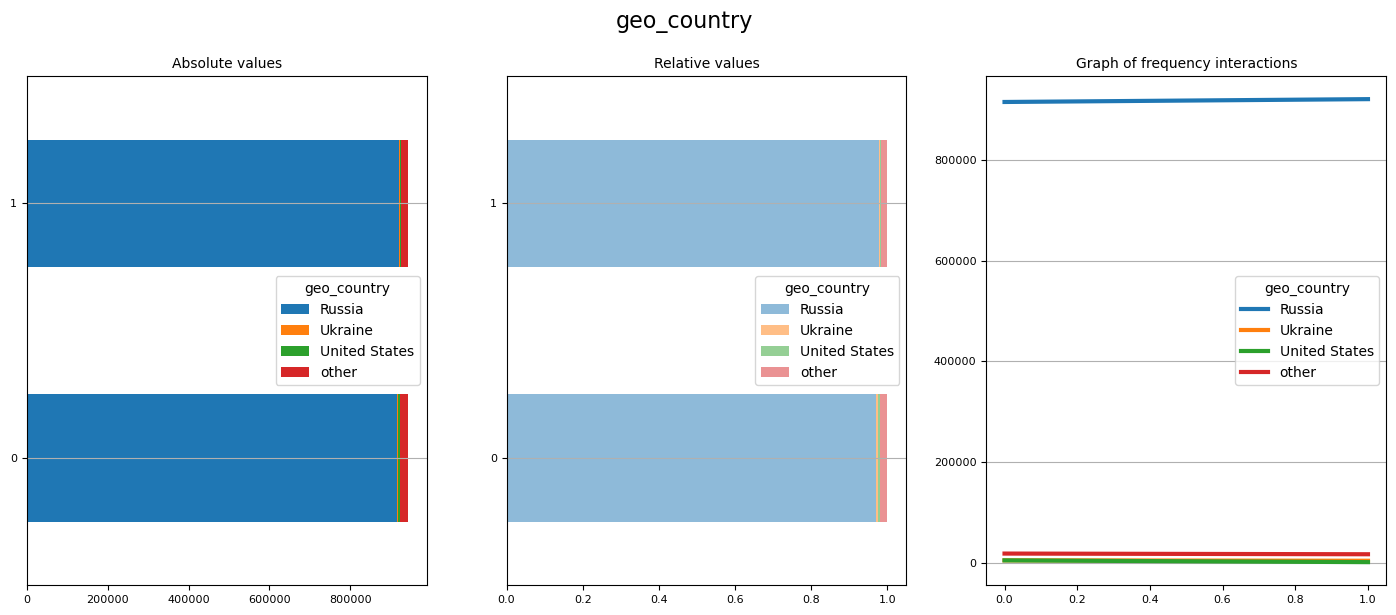


Absolute values:


geo_country,Russia,Ukraine,United States,other,sum
target,,,,,
0,914795,4591,4509,18036,941931
1,920443,3769,1034,16685,941931



Relative values:


geo_country,Russia,Ukraine,United States,other,sum
target,,,,,
0,0.971191,0.004874,0.004787,0.019148,1.0
1,0.977187,0.004001,0.001098,0.017714,1.0


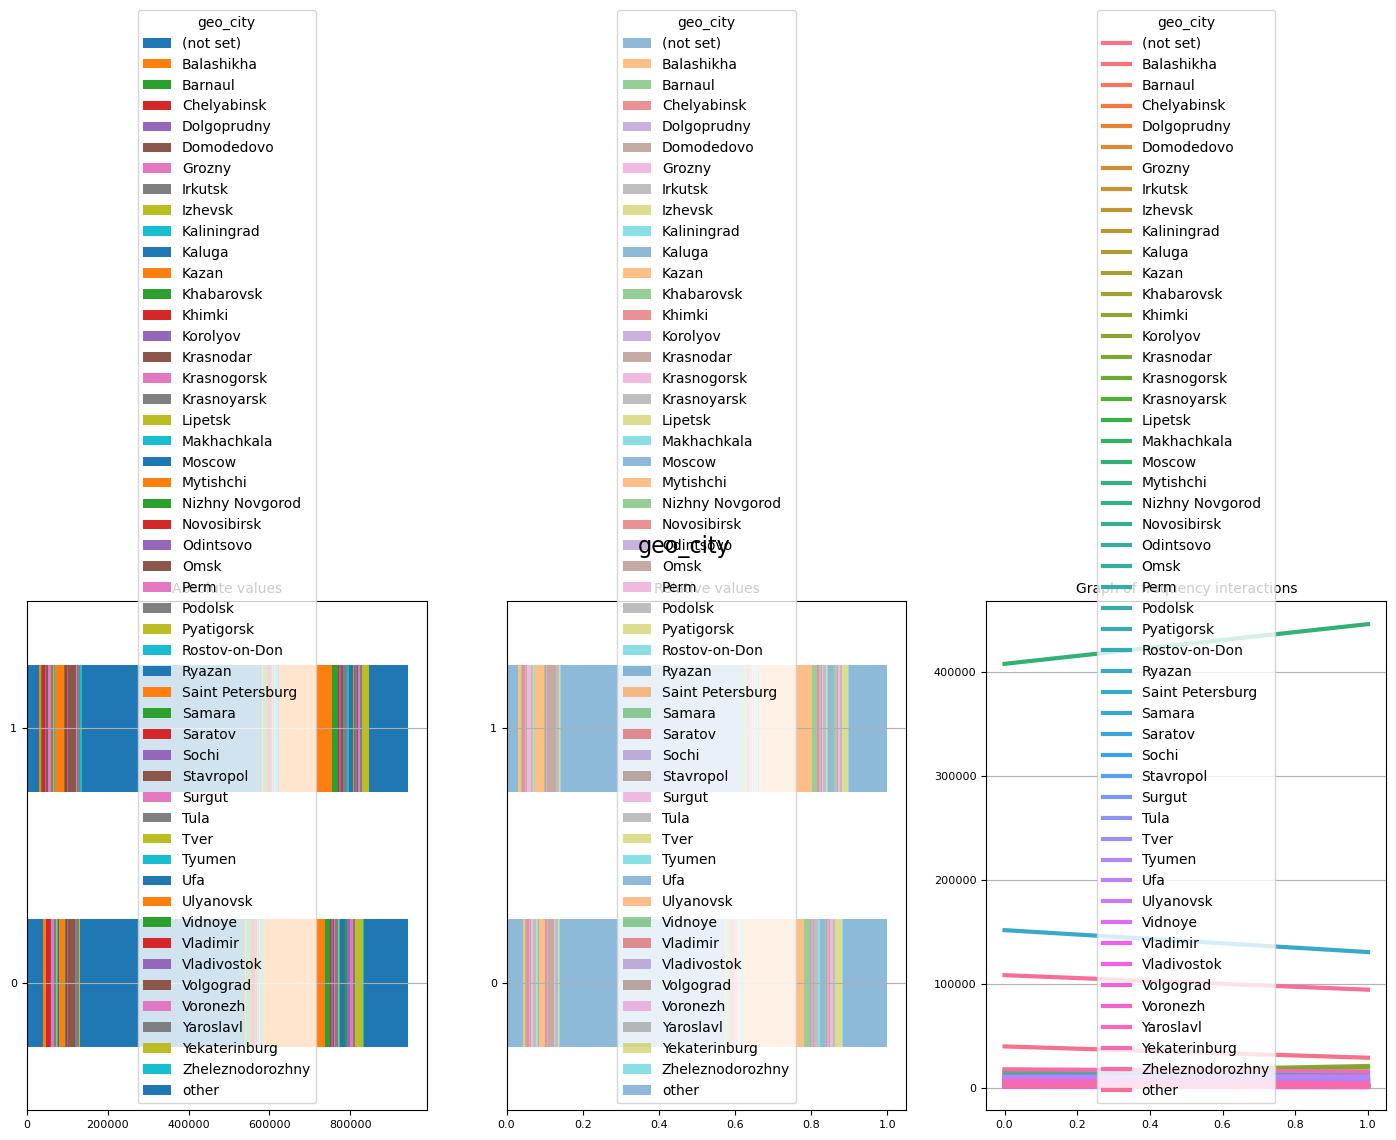


Absolute values:


geo_city,(not set),Balashikha,Barnaul,Chelyabinsk,Dolgoprudny,Domodedovo,Grozny,Irkutsk,Izhevsk,Kaliningrad,...,Vidnoye,Vladimir,Vladivostok,Volgograd,Voronezh,Yaroslavl,Yekaterinburg,Zheleznodorozhny,other,sum
target,,,,,,,,,,,,,,,,,,,,,
0,40201,6405,1487,8200,1341,1936,6443,6837,2657,1961,...,2770,1352,6224,2035,7058,4986,18279,2513,108616,941931
1,29368,6577,1178,7954,1792,4620,7731,5856,2192,1808,...,2869,1402,4701,1637,5444,4554,16152,1952,94685,941931



Relative values:


geo_city,(not set),Balashikha,Barnaul,Chelyabinsk,Dolgoprudny,Domodedovo,Grozny,Irkutsk,Izhevsk,Kaliningrad,...,Vidnoye,Vladimir,Vladivostok,Volgograd,Voronezh,Yaroslavl,Yekaterinburg,Zheleznodorozhny,other,sum
target,,,,,,,,,,,,,,,,,,,,,
0,0.042679,0.006800,0.001579,0.008706,0.001424,0.002055,0.006840,0.007258,0.002821,0.002082,...,0.002941,0.001435,0.006608,0.002160,0.007493,0.005293,0.019406,0.002668,0.115312,1.0
1,0.031179,0.006982,0.001251,0.008444,0.001902,0.004905,0.008208,0.006217,0.002327,0.001919,...,0.003046,0.001488,0.004991,0.001738,0.005780,0.004835,0.017148,0.002072,0.100522,1.0


In [79]:
for col in cat_cols:
    pivot = df_over.pivot_table(
    values='session_id',
    index='target',
    columns=col,
    aggfunc='count',
    fill_value=0,
    margins=True)

    pivot = pivot.iloc[:-1,:-1]
    
    graph_contingency_tables_bar_freqint(
    data_df_in=pivot,
    graph_inclusion='arf',
    title_figure = col, title_figure_fontsize = 16,
    result_output=True,
    tight_layout=False,
    graph_size=(297/INCH*1.5, 210/INCH/1.25)
    )


In [80]:
df_over.loc[~df_over['utm_source'].isin(df['utm_source'].value_counts().head(10).index),'utm_source'] = 'other'
df_over.loc[~df_over['utm_campaign'].isin(df['utm_campaign'].value_counts().head(7).index),'utm_campaign'] = 'other'
df_over.loc[~df_over['utm_keyword'].isin(df['utm_keyword'].value_counts().head(3).index),'utm_keyword'] = 'other'
df_over.loc[~df_over['device_brand'].isin(df['device_brand'].value_counts().head(6).index),'device_brand'] = 'other'
df_over.loc[~df_over['geo_city'].isin(df['geo_city'].value_counts().head(5).index),'geo_city'] = 'other'

del df_over['geo_country']



In [81]:
cat_cols = list(cat_cols)

In [82]:
del cat_cols[-2]

In [83]:

# pivot = df_over.pivot_table(
# values='session_id',
# index='target',
# columns='utm_source',
# aggfunc='count',
# fill_value=0,
# margins=True)

# pivot = pivot.iloc[:-1,:-1]
# pivot =pivot.sort_values(by=0,axis=1,ascending=False)

# graph_contingency_tables_bar_freqint(
# data_df_in=pivot,
# graph_inclusion='af',
# title_figure = 'utm_source', title_figure_fontsize = 16,
# result_output=True,
# tight_layout=False,
# graph_size=(297/INCH*1.5, 210/INCH/1.25)
# )


In [84]:
# for col in cat_cols:
#     pivot = df_over.pivot_table(
#     values='session_id',
#     index='target',
#     columns=col,
#     aggfunc='count',
#     fill_value=0,
#     margins=True)

#     pivot = pivot.iloc[:-1,:-1]
#     pivot =pivot.sort_values(by=0,axis=1,ascending=False)
    
#     graph_contingency_tables_bar_freqint(
#     data_df_in=pivot,
#     graph_inclusion='af',
#     title_figure = col, title_figure_fontsize = 16,
#     result_output=True,
#     tight_layout=False,
#     graph_size=(297/INCH*1.5, 210/INCH/1.25)
#     )


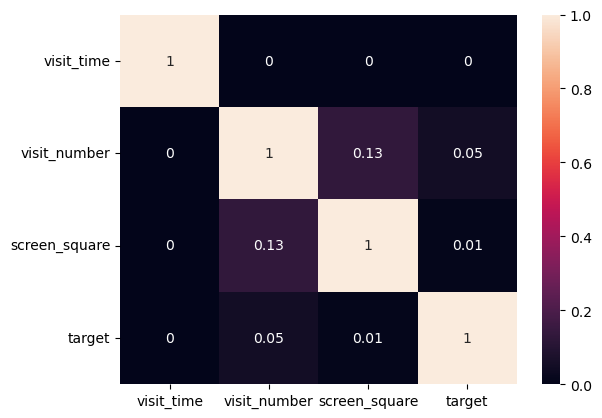

In [85]:
matrix = df_over.select_dtypes('number').corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

In [86]:
numerical = df_over.select_dtypes('number').drop(columns='target')
categorical = df_over.select_dtypes('object').drop(columns='session_id')

scaler = MinMaxScaler()

for col in numerical.columns:

    df_over[col] = scaler.fit_transform(df_over[[col]])


to_encode = categorical.columns

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(df_over[to_encode])

df_over[ohe.get_feature_names_out()] = ohe.transform(df_over[to_encode])

df_over = df_over.drop(columns=categorical.columns).drop(columns='session_id')

In [87]:
df_ml = df_over.copy()

In [88]:
X_train = df_ml.drop(['target'], axis=1)
y_train = df_ml['target']


In [89]:
df_valid = X_valid.copy()
df_valid['target'] = y_valid

In [90]:
df_valid.loc[~df_valid['utm_source'].isin(df['utm_source'].value_counts().head(10).index),'utm_source'] = 'other'
df_valid.loc[~df_valid['utm_campaign'].isin(df['utm_campaign'].value_counts().head(7).index),'utm_campaign'] = 'other'
df_valid.loc[~df_valid['utm_keyword'].isin(df['utm_keyword'].value_counts().head(3).index),'utm_keyword'] = 'other'
df_valid.loc[~df_valid['device_brand'].isin(df['device_brand'].value_counts().head(6).index),'device_brand'] = 'other'
df_valid.loc[~df_valid['geo_city'].isin(df['geo_city'].value_counts().head(5).index),'geo_city'] = 'other'

del df_valid['geo_country']

numerical = df_valid.select_dtypes('number').drop(columns='target')
categorical = df_valid.select_dtypes('object').drop(columns='session_id')

scaler = MinMaxScaler()

for col in numerical.columns:

    df_valid[col] = scaler.fit_transform(df_valid[[col]])


to_encode = categorical.columns

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(df_valid[to_encode])

df_valid[ohe.get_feature_names_out()] = ohe.transform(df_valid[to_encode])

df_valid = df_valid.drop(columns=categorical.columns).drop(columns='session_id')

In [91]:
y_valid = df_valid['target']
X_valid = df_valid.drop(columns='target')

In [92]:
from catboost import CatBoostClassifier



# Создание и обучение модели CatBoost
cbc = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_state=42)
cbc.fit(X_train, y_train)

# Оценка качества модели на тестовой выборке
accuracy = cbc.score(X_valid, y_valid)
print(f"Accuracy: {accuracy:.2f}")


0:	learn: 0.6849495	total: 105ms	remaining: 10.4s
1:	learn: 0.6783120	total: 161ms	remaining: 7.9s
2:	learn: 0.6730575	total: 214ms	remaining: 6.93s
3:	learn: 0.6689781	total: 263ms	remaining: 6.32s
4:	learn: 0.6648504	total: 320ms	remaining: 6.08s
5:	learn: 0.6618337	total: 375ms	remaining: 5.87s
6:	learn: 0.6592188	total: 428ms	remaining: 5.69s
7:	learn: 0.6571777	total: 491ms	remaining: 5.65s
8:	learn: 0.6551097	total: 548ms	remaining: 5.54s
9:	learn: 0.6536115	total: 602ms	remaining: 5.42s
10:	learn: 0.6515814	total: 659ms	remaining: 5.33s
11:	learn: 0.6504159	total: 713ms	remaining: 5.23s
12:	learn: 0.6491792	total: 769ms	remaining: 5.15s
13:	learn: 0.6478997	total: 827ms	remaining: 5.08s
14:	learn: 0.6471163	total: 878ms	remaining: 4.98s
15:	learn: 0.6462076	total: 933ms	remaining: 4.9s
16:	learn: 0.6454624	total: 987ms	remaining: 4.82s
17:	learn: 0.6445915	total: 1.05s	remaining: 4.77s
18:	learn: 0.6438511	total: 1.1s	remaining: 4.69s
19:	learn: 0.6432590	total: 1.15s	remaining:

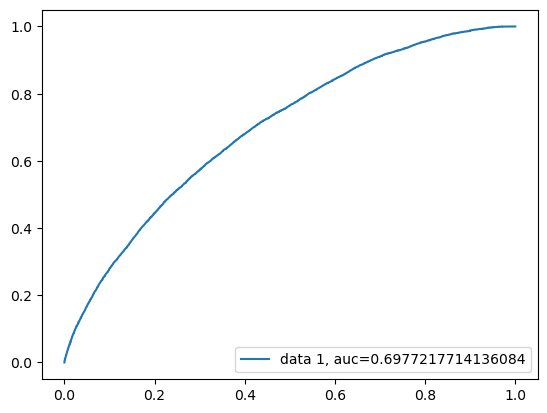

In [93]:
y_pred_proba = cbc.predict_proba(X_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid,  y_pred_proba)
auc = roc_auc_score(y_valid, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [94]:
from xgboost import XGBClassifier


# Создание и обучение модели XGBoost
xc = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xc.fit(X_train, y_train)

# Оценка качества модели на тестовой выборке
accuracy = xc.score(X_valid, y_valid)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.60


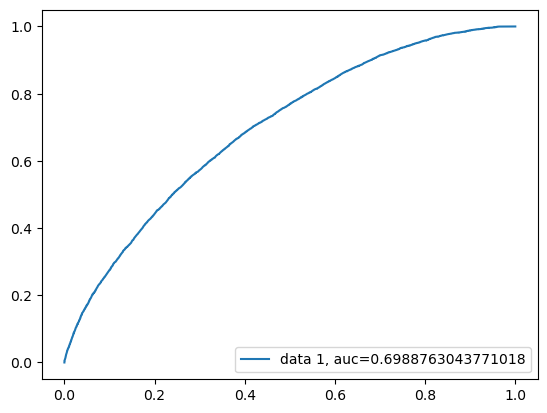

In [95]:
y_pred_proba = xc.predict_proba(X_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid,  y_pred_proba)
auc = roc_auc_score(y_valid, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [96]:
from lightgbm import LGBMClassifier


# Создание и обучение модели LightGBM
lc = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
lc.fit(X_train, y_train)

# Оценка качества модели на тестовой выборке
accuracy = lc.score(X_valid, y_valid)
print(f"Accuracy: {accuracy:.2f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 941931, number of negative: 941931
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 1883862, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Accuracy: 0.59


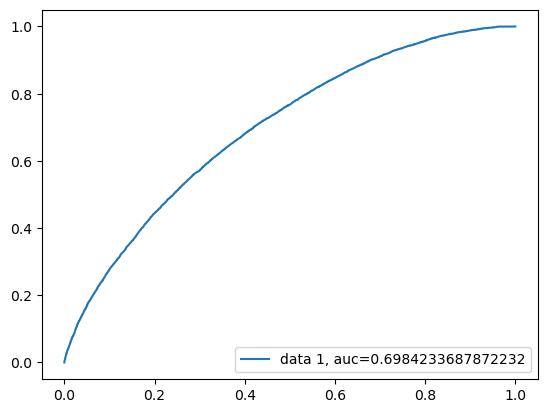

In [97]:
y_pred_proba = lc.predict_proba(X_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid,  y_pred_proba)
auc = roc_auc_score(y_valid, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [98]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train,y_train)
predicted_train = gnb.predict(X_train)
predicted_valid = gnb.predict(X_valid)

print(accuracy_score(y_train,predicted_train), accuracy_score(y_valid,predicted_valid))


0.5485789298791525 0.1640744192183673


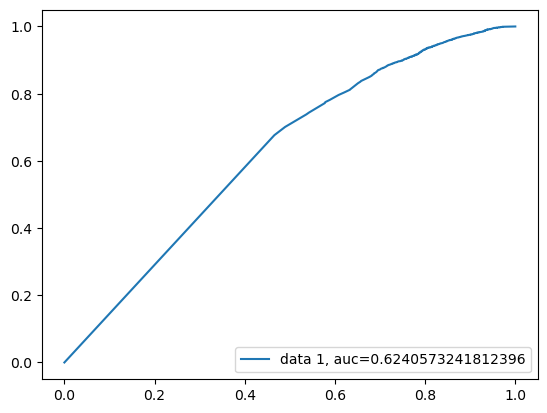

In [99]:
y_pred_proba = gnb.predict_proba(X_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid,  y_pred_proba)
auc = roc_auc_score(y_valid, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [100]:
log = LogisticRegression()
log.fit(X_train,y_train)
predicted_train = log.predict(X_train)
predicted_valid = log.predict(X_valid)

print(accuracy_score(y_train,predicted_train), accuracy_score(y_valid,predicted_valid))

0.6240611042634758 0.5629808921399648


/home/alexander/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


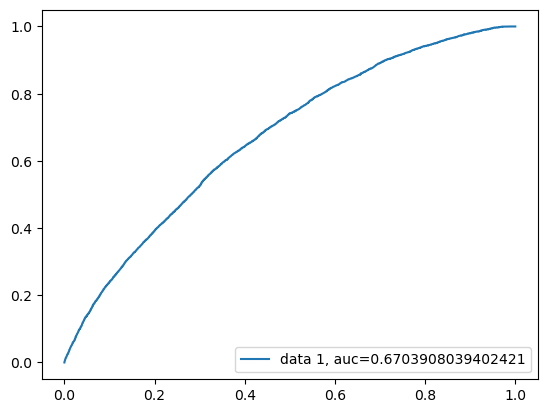

In [101]:
y_pred_proba = log.predict_proba(X_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid,  y_pred_proba)
auc = roc_auc_score(y_valid, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [102]:
rf = RandomForestClassifier(random_state=43)
rf.fit(X_train,y_train)
predicted_train = rf.predict(X_train)
predicted_valid = rf.predict(X_valid)

print(accuracy_score(y_train,predicted_train), accuracy_score(y_valid,predicted_valid))




0.8987696551021254 0.81862377225608


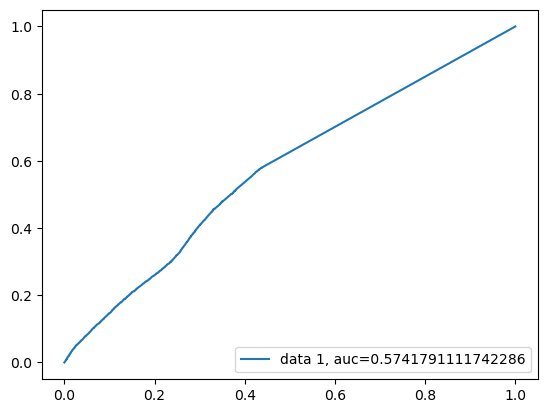

In [103]:
y_pred_proba = rf.predict_proba(X_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid,  y_pred_proba)
auc = roc_auc_score(y_valid, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [104]:
from sklearn.calibration import CalibrationDisplay


clf_list = [
    (log, "Logistic Regression"),
    (gnb, "Naive Bayes"),
    (cbc, "CatBoostClassifier"),
    (lc,'LGBMClassifier'),
    (rf, "Random forest"),
    (xc, "XGBClassifier"),
]

/home/alexander/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/alexander/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/home/alexander/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword 

0:	learn: 0.6849495	total: 47.5ms	remaining: 4.7s
1:	learn: 0.6783120	total: 99.9ms	remaining: 4.89s
2:	learn: 0.6730575	total: 158ms	remaining: 5.1s
3:	learn: 0.6689781	total: 208ms	remaining: 4.99s
4:	learn: 0.6648504	total: 266ms	remaining: 5.05s
5:	learn: 0.6618337	total: 322ms	remaining: 5.04s
6:	learn: 0.6592188	total: 379ms	remaining: 5.04s
7:	learn: 0.6571777	total: 437ms	remaining: 5.02s
8:	learn: 0.6551097	total: 545ms	remaining: 5.51s
9:	learn: 0.6536115	total: 603ms	remaining: 5.43s
10:	learn: 0.6515814	total: 660ms	remaining: 5.34s
11:	learn: 0.6504159	total: 717ms	remaining: 5.26s
12:	learn: 0.6491792	total: 777ms	remaining: 5.2s
13:	learn: 0.6478997	total: 833ms	remaining: 5.12s
14:	learn: 0.6471163	total: 889ms	remaining: 5.04s
15:	learn: 0.6462076	total: 942ms	remaining: 4.94s
16:	learn: 0.6454624	total: 992ms	remaining: 4.84s
17:	learn: 0.6445915	total: 1.05s	remaining: 4.77s
18:	learn: 0.6438511	total: 1.1s	remaining: 4.68s
19:	learn: 0.6432590	total: 1.15s	remaining

/home/alexander/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 941931, number of negative: 941931
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 1883862, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/alexander/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/home/alexander/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/home/alexander/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]


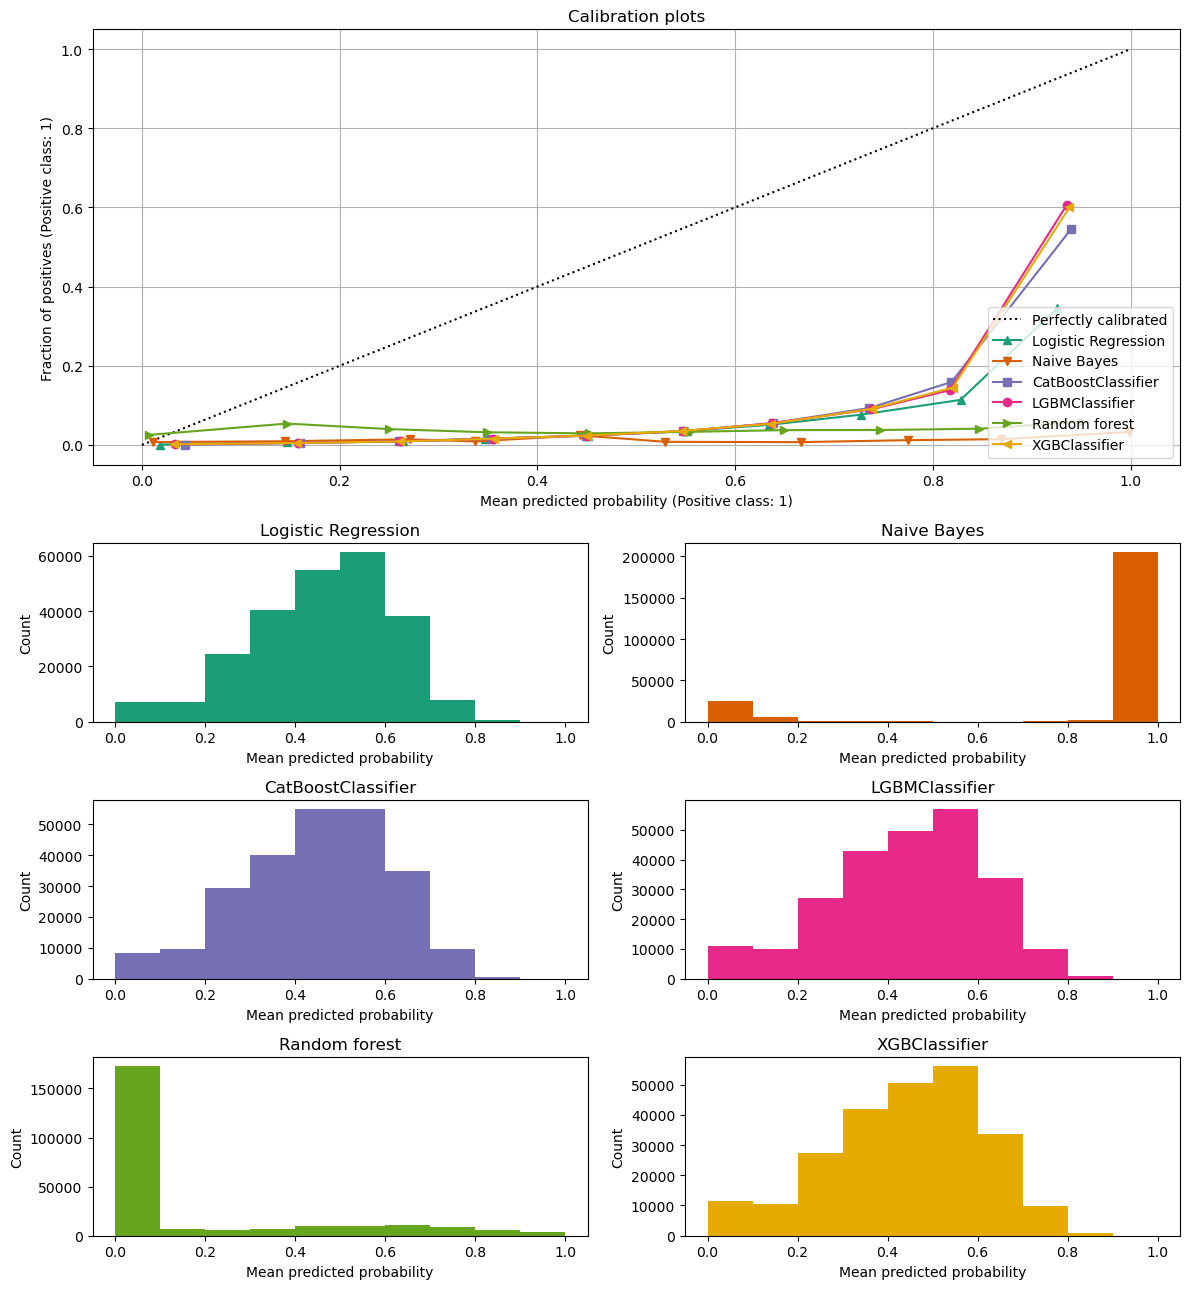

In [105]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay
import math

# Предполагается, что clf_list уже определен
n_classifiers = len(clf_list)

# Рассчитываем количество строк для гистограмм
n_hist_rows = math.ceil(n_classifiers / 2)

fig = plt.figure(figsize=(12, 4 + 3 * n_hist_rows))
gs = GridSpec(2 + n_hist_rows, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :])
calibration_displays = {}
markers = ["^", "v", "s", "o", '>', '<', 'D', 'p', '*', 'h', 'H', '+', 'x', 'd', '|', '_']

# Убедитесь, что у вас достаточно маркеров для всех классификаторов
if n_classifiers > len(markers):
    markers = markers * (n_classifiers // len(markers) + 1)

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_valid,
        y_valid,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i % colors.N),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histograms
for i, (_, name) in enumerate(clf_list):
    row = 2 + i // 2
    col = i % 2
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i % colors.N),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()


In [106]:

clf_list = [
    # (log, "Logistic Regression"),
    # (gnb, "Naive Bayes"),
    # (cbc, "CatBoostClassifier"),
    (lc,'LGBMClassifier'),
    # (rf, "Random forest"),
    (xc, "XGBClassifier"),
]

In [107]:
clf_list_r = [(x[1],x[0]) for x in clf_list]

In [108]:
# del clf_list_r[3]

In [109]:
eclf1 = VotingClassifier(estimators=clf_list_r, voting='soft')

eclf1 = eclf1.fit(X_train, y_train)

print(eclf1.predict(X_valid))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 941931, number of negative: 941931
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 1883862, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[0 1 0 ... 1 1 0]


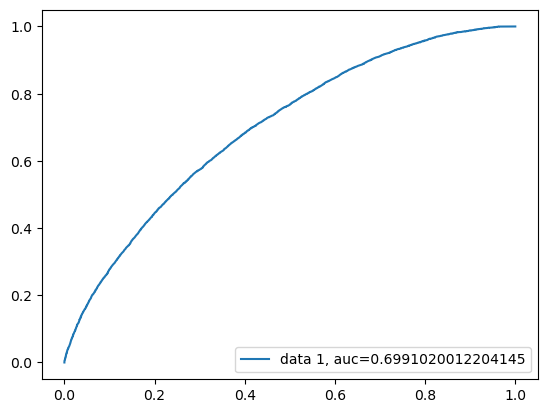

In [110]:
y_pred_proba = eclf1.predict_proba(X_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid,  y_pred_proba)
auc = roc_auc_score(y_valid, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [111]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
# Создаем мета-модель
final_estimator = GradientBoostingClassifier()

# Создаем StackingClassifier
SC = StackingClassifier(estimators=clf_list_r, final_estimator=final_estimator)

# Обучаем модель
SC.fit(X_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 941931, number of negative: 941931
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 1883862, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 753545, number of negative: 753544
[LightGBM] [Info] Auto-choosing row-

StackingClassifier(estimators=[('LGBMClassifier',
                                LGBMClassifier(max_depth=6, random_state=42)),
                               ('XGBClassifier',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gro...
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=GradientBoostingClassifier())

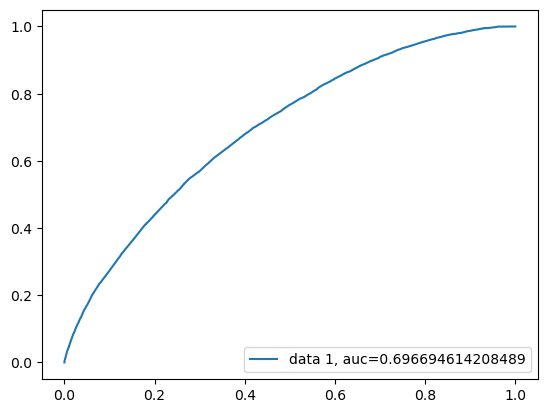

In [112]:
y_pred_proba = SC.predict_proba(X_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid,  y_pred_proba)
auc = roc_auc_score(y_valid, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [113]:
c = df_ml.corr().round(2)


In [114]:
c['target'].sort_values()

utm_campaign_FTjNLDyTrXaWYgZymFkV    -0.16
utm_medium_cpm                       -0.15
utm_source_other                     -0.12
utm_campaign_other                   -0.11
utm_source_MvfHsxITijuriZxsqZqt      -0.11
                                      ... 
utm_source_bByPQxmDaMXgpHeypKSM       0.11
utm_medium_referral                   0.13
utm_adcontent_JNHcPlZPxEMWDnRiyoBf    0.14
utm_campaign_LTuZkdKfxRGVceoWkVyg     0.15
target                                1.00
Name: target, Length: 80, dtype: float64

In [115]:
# cross_validate(rf, X, y, cv=5, scoring='accuracy')

# Получаем только значения метрик на тестовых фолдах




In [116]:
y_valid

1434067    0
1147928    0
160653     0
1505953    0
1691526    0
          ..
293394     0
978570     0
1166282    0
728622     0
826675     0
Name: target, Length: 242518, dtype: int64

In [117]:
y_pred_proba = rf.predict_proba(X_valid)[::,1]

In [118]:
y_pred_proba

array([0.        , 0.66975681, 0.        , ..., 0.02      , 0.0159342 ,
       0.        ])

In [119]:
y_valid.values

array([0, 0, 0, ..., 0, 0, 0])

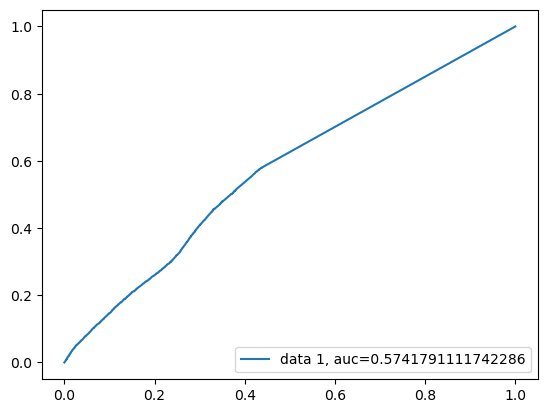

In [120]:
fpr, tpr, _ = roc_curve(y_valid,  y_pred_proba)
auc = roc_auc_score(y_valid, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [121]:
auc

0.5741791111742286

In [122]:
y_train.value_counts()

target
0    941931
1    941931
Name: count, dtype: int64

In [123]:
y_valid.value_counts()

target
0    235484
1      7034
Name: count, dtype: int64

In [124]:
classes = (y_pred_proba > disbalance).astype(int)
classes = (y_pred_proba > 0.02987137075712472).astype(int)



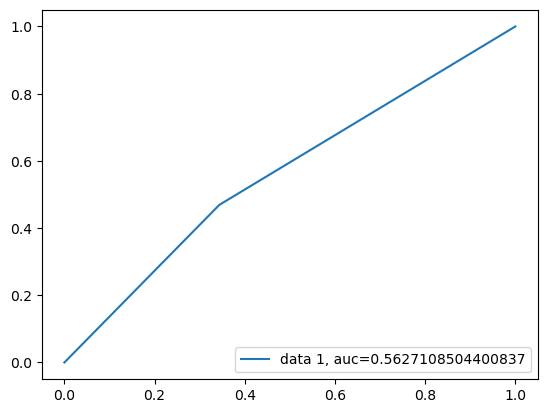

In [125]:
fpr, tpr, _ = roc_curve(y_valid,  classes)
auc = roc_auc_score(y_valid, classes)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

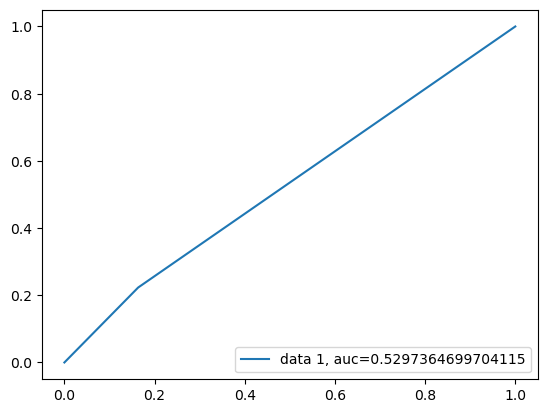

In [126]:
fpr, tpr, _ = roc_curve(y_valid,  predicted_valid)
auc = roc_auc_score(y_valid, predicted_valid)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [127]:
import eli5
eli5.show_weights(rf,feature_names=list(X_valid.columns))

2024-07-14 15:18:34.621664: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-14 15:18:34.623676: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-14 15:18:34.704612: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-14 15:18:35.044304: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-14 15:18:35.966938: W tensorflow/compiler/tf2tensorrt/utils/py_uti

Weight,Feature
0.3752 ± 0.0252,visit_time
0.2572 ± 0.0244,screen_square
0.1063 ± 0.0245,visit_number
0.0119 ± 0.0038,geo_city_Moscow
0.0111 ± 0.0028,geo_city_other
0.0111 ± 0.0124,utm_campaign_other
0.0101 ± 0.0121,utm_source_other
0.0095 ± 0.0020,device_browser_Chrome
0.0095 ± 0.0024,geo_city_Saint Petersburg
0.0094 ± 0.0172,utm_adcontent_JNHcPlZPxEMWDnRiyoBf


In [128]:
param_grid = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}
# log_reg = LogisticRegression(random_state=42)
grid_search = GridSearchCV(log_reg, param_grid, cv=5)

NameError: name 'GridSearchCV' is not defined

In [135]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import optuna

def objective_log(trial):
    C = trial.suggest_float('alpha', 1e-2, 1e+2, log=True)
    random_state = trial.suggest_int('random_state', 1, 1000)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    model = LogisticRegression(C=C, solver=solver, penalty=penalty, max_iter=2000, verbose=True, random_state=random_state)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)
    roc_auc = roc_auc_score(y_valid, y_pred)
    return -roc_auc  # Возвращаем отрицательное значение для максимизации

# Предполагается, что X_train, y_train, X_valid, y_valid уже определены
study_log = optuna.create_study(direction='maximize')  # Указываем, что хотим максимизировать значение
study_log.optimize(objective_log, n_trials=100)


[I 2024-07-14 15:53:24,225] A new study created in memory with name: no-name-71c0a473-b378-4a01-aef5-d19b9c3b8aa7


[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 3
iter   4  #CD cycles 1
iter   5  #CD cycles 12
iter   6  #CD cycles 1
iter   7  #CD cycles 37
iter   8  #CD cycles 8
iter   9  #CD cycles 2
iter  10  #CD cycles 2
iter  11  #CD cycles 1
iter  12  #CD cycles 138
iter  13  #CD cycles 15
iter  14  #CD cycles 7
iter  15  #CD cycles 5
iter  16  #CD cycles 1


In [ ]:
от рекомендации по подбору параметров для перечисленных моделей:

1. Logistic Regression:

    penalty: 'l1' или 'l2' для регуляризации. 'l1' может привести к более разреженным моделям.
    C: Параметр регуляризации. Более высокие значения C приводят к меньшему регуляризации.
    solver: 'liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'. Выбор зависит от размера данных и типа задачи.

2. Naive Bayes:

    var_smoothing: Параметр сглаживания для предотвращения нулевых вероятностей.

3. CatBoostClassifier:

    iterations: Количество деревьев.
    learning_rate: Скорость обучения.
    depth: Максимальная глубина деревьев.
    l2_leaf_reg: L2-регуляризация листьев.
    border_count: Количество бинов для числовых признаков.

4. LGBMClassifier:

    n_estimators: Количество деревьев.
    learning_rate: Скорость обучения.
    max_depth: Максимальная глубина деревьев.
    num_leaves: Максимальное количество листьев в дереве.
    feature_fraction: Доля признаков, используемых в каждом дереве.

5. Random Forest:

    n_estimators: Количество деревьев.
    max_depth: Максимальная глубина деревьев.
    min_samples_split: Минимальное количество образцов, необходимое для разделения узла.
    min_samples_leaf: Минимальное количество образцов, необходимое для листа.
    max_features: Количество признаков, рассматриваемых при построении каждого дерева.

6. XGBClassifier:

    n_estimators: Количество деревьев.
    learning_rate: Скорость обучения.
    max_depth: Максимальная глубина деревьев.
    subsample: Доля данных, используемых для построения каждого дерева.
    colsample_bytree: Доля признаков, используемых в каждом дереве.

Общие рекомендации:

    Используйте кросс-валидацию: Для оценки производительности моделей и выбора оптимальных параметров.
    Начните с дефолтных параметров: Затем постепенно изменяйте параметры, наблюдая за изменением производительности.
    Используйте GridSearchCV или RandomizedSearchCV: Для автоматического поиска оптимальных параметров.
    Не переобучайте: Следите за переобучением и используйте регуляризацию, если необходимо.
    Документация: Ознакомьтесь с документацией каждой модели для получения более подробной информации о параметрах.

Помните:

    Оптимальные параметры зависят от конкретной задачи и данных.
    Экспериментируйте и не бойтесь пробовать разные подходы.



Подбор параметров для машинных обучения моделей является критическим шагом для достижения наилучшей производительности. Существует несколько методов подбора параметров, включая grid search, random search, Bayesian optimization и др. Ниже приведены рекомендации по подбору параметров для указанных моделей на основе библиотеки scikit-learn и связанных библиотек (CatBoost, LightGBM, XGBoost):

    Logistic Regression
        Параметры для подбора: C (регуляризация), penalty (тип регуляризации), solver (алгоритм оптимизации).
        Метод подбора: Grid Search или Random Search с кросс-валидацией.

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}
log_reg = LogisticRegression(random_state=42)
grid_search = GridSearchCV(log_reg, param_grid, cv=5)

Naive Bayes

    Параметры для подбора: var_smoothing (для GaussianNB), alpha (для MultinomialNB или BernoulliNB).
    Метод подбора: Grid Search или Random Search с кросс-валидацией.

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

param_grid = {'var_smoothing': [1e-9, 1e-10, 1e-11]}
nb = GaussianNB()
grid_search = GridSearchCV(nb, param_grid, cv=5)

CatBoostClassifier

    Параметры для подбора: iterations, learning_rate, depth, l2_leaf_reg, random_strength, bagging_temperature и др.
    Метод подбора: Grid Search, Random Search или CatBoost's built-in GridSearchCV с кросс-валидацией.

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV

param_grid = {'iterations': [100, 300, 500], 'learning_rate': [0.03, 0.1, 0.3], 'depth': [4, 6, 8]}
cat_model = CatBoostClassifier(random_state=42)
grid_search = GridSearchCV(cat_model, param_grid, cv=5)

LGBMClassifier

    Параметры для подбора: n_estimators, learning_rate, num_leaves, max_depth, reg_alpha, reg_lambda и др.
    Метод подбора: Grid Search, Random Search или LightGBM's built-in cv метод с кросс-валидацией.

from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 300, 500], 'learning_rate': [0.01, 0.1, 0.3], 'num_leaves': [16, 32, 64]}
lgbm_model = LGBMClassifier(random_state=42)
grid_search = GridSearchCV(lgbm_model, param_grid, cv=5)

Random Forest

    Параметры для подбора: n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features и др.
    Метод подбора: Grid Search, Random Search с кросс-валидацией.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 300, 500], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5, 10]}
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5)

XGBClassifier

    Параметры для подбора: n_estimators, learning_rate, max_depth, min_child_weight, gamma, subsample, colsample_bytree и др.
    Метод подбора: Grid Search, Random Search или XGBoost's built-in cv метод с кросс-валидацией.

    from xgboost import XGBClassifier
    from sklearn.model_selection import GridSearchCV

    param_grid = {'n_estimators': [100, 300, 500], 'learning_rate': [0.01, 0.1, 0.3], 'max_depth': [3, 5, 7]}
    xgb_model = XGBClassifier(random_state=42)
    grid_search = GridSearchCV(xgb_model, param_grid, cv=5)

Для всех моделей важно использовать кросс-валидацию (cv в GridSearchCV или RandomizedSearchCV) для более точной оценки производительности модели с различными наборами параметров. Кроме того, если пространство параметров очень велико, Random Search может быть более эффективным, чем Grid Search, так как он случайным образом исследует пространство параметров.

Также можно использовать более сложные методы, такие как Bayesian optimization с помощью библиотеки scikit-optimize или hyperopt, которые могут быть более эффективными при поиске оптимальных параметров в сложных пространствах.

Не забудьте, что подбор параметров может быть вычислительно затратным, особенно для сложных моделей и больших наборов данных, поэтому может потребоваться соответствующее оборудование или использование распределенных вычислений.